In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" #指定使用的GPU
import torch
import shutil
import numpy as np
import multiprocessing #多线程处理
import cv2
import matplotlib.pyplot as plt #绘图


import rosbag #处理rosbag
from cv_bridge import CvBridge

import sys
sys.path.append('/home/gwp/rpg_vid2e/rosbag_reading')  # 替换为实际的路径(注意如果修改了py文件的代码需要重新restart kernel)
from utils.bag_utils import read_H_W_from_bag, read_tss_us_from_rosbag, read_images_from_rosbag, read_evs_from_rosbag, read_evs_from_rosbag_intimestamp
print("import ultils to process the rosbag")

/home/gwp/miniconda3/envs/vid2e/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


import ultils to process the rosbag


In [2]:
rosbag_file="../example/HKU-dataset/HKU_aggressive_small_flip.bag"
# 从rosbag文件中读取数据
bag_data = rosbag.Bag(rosbag_file, "r")

topics = list(bag_data.get_type_and_topic_info()[1].keys())
print("all the topic name in this rosbag",topics)

all the topic name in this rosbag ['/cpy_uav/viconros/odometry', '/davis_left/events', '/davis_left/image_raw', '/davis_left/imu', '/davis_right/events', '/davis_right/image_raw', '/davis_right/imu']


In [5]:
image_topic_name='/davis_left/image_raw';

# 读取图像的长与宽
H, W = read_H_W_from_bag(bag_data, image_topic_name)
# 读取全部图像数据
imgs = read_images_from_rosbag(bag_data, image_topic_name, H=H, W=W)


Read H, W from bag: 260, 346


 27%|██▋       | 458/1726 [00:11<00:24, 52.47it/s]

 62%|██████▏   | 1068/1726 [00:26<00:15, 42.20it/s]

100%|██████████| 1726/1726 [00:42<00:00, 40.47it/s]


extract num of image 10


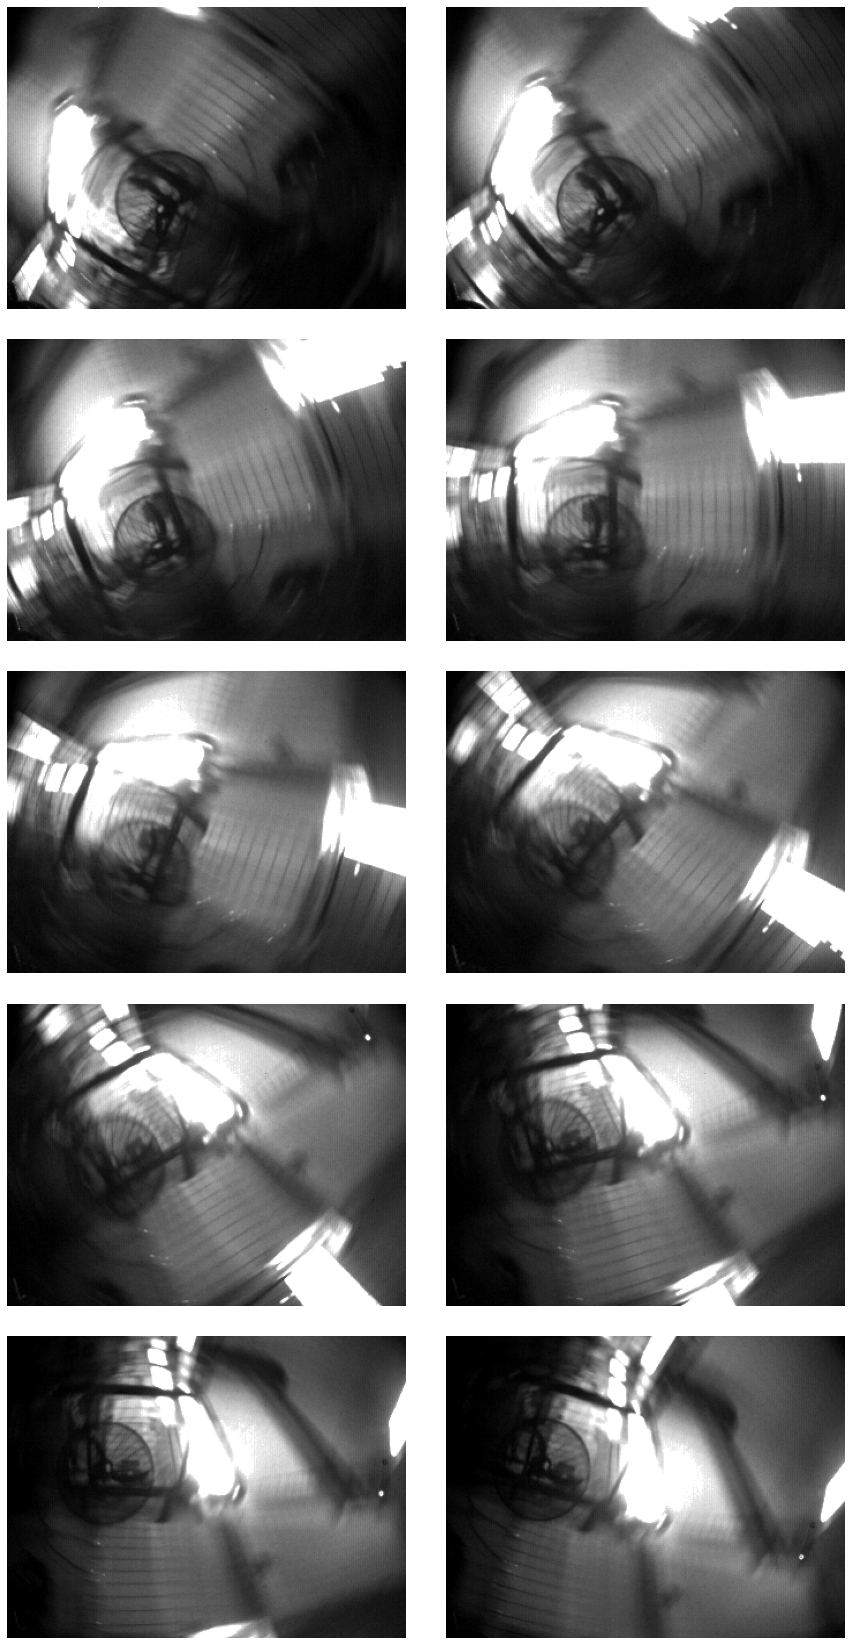

timestamp of the first image 1666334010130768.8 
timestamp of the last image 1666334010518417.8
the hz of the image topic is:  25


In [6]:
# 获取一组图片
image_index=900;
image_set=imgs[image_index:image_index+10]#提取10张图片
print("extract num of image",len(image_set))

# 将十张图片都显示出来

# 定义子图的行和列
rows = 5
cols = 2

# 创建一个图形对象，并定义子图的尺寸
fig, axes = plt.subplots(rows, cols, figsize=(15, 30))

# 同时将图片也保存出来
images_dir = os.path.join(os.path.dirname(rosbag_file), 'imgs')
if os.path.exists(images_dir): # 如果目标目录存在，则删除它
    shutil.rmtree(images_dir)
else:
    os.makedirs(images_dir) # 如果不存在就创建目标目录

# 遍历每一张图片，并显示在相应的子图中
for i, image in enumerate(image_set):
    ax = axes[i // cols, i % cols]
    # image_color = np.stack([image, image, image], -1)  # 将灰度图像转换为RGB图像

    # 保存图片
    img_filename = f"img_{i:08d}.png"
    img_path = os.path.join(images_dir, img_filename)
    cv2.imwrite(img_path, image)  # 使用cv2.imwrite保存图片

    image_color = image[:, :, None].repeat(3, axis=2) # 把real event画在image上, (H,W) -> (H,W,1) -> (H,W,3)
    ax.imshow(image_color, aspect='auto') # 保持原图像比例
    ax.axis('off')  # 不显示坐标轴

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# 读取图像的时间戳
timestamp_imgs_us = read_tss_us_from_rosbag(bag_data, image_topic_name)
#提取上面选择的10张图片对应的时间戳
timestamp_imgs_us_set=timestamp_imgs_us[image_index:image_index+10]
assert len(timestamp_imgs_us_set) == len(image_set)

timestamp_us_0=timestamp_imgs_us_set[0];#第一张图片的时间戳
timestamp_us_1=timestamp_imgs_us_set[-1];#最后一张图片的时间戳
print("timestamp of the first image",timestamp_us_0,"\ntimestamp of the last image",timestamp_us_1)
frequency_hz_image=int(1e6/(timestamp_us_1-timestamp_us_0)*len(timestamp_imgs_us_set))#计算帧率
print("the hz of the image topic is: ",frequency_hz_image)

fps_file_path = os.path.join(os.path.dirname(rosbag_file), 'fps.txt')
# 如果fps.txt文件存在，则删除它
if os.path.exists(fps_file_path):
    os.remove(fps_file_path)

# 将频率写入fps.txt文件
with open(fps_file_path, 'w') as f:
    f.write(f"{frequency_hz_image}")

In [3]:
# 清理sys.path，防止冲突
# sys.path.pop()
sys.path.append('/home/gwp/rpg_vid2e')  # 替换为实际的路径，这个路径包含了upsampling目录
from upsampling.utils.upsampler import Upsampler
print("导入Upsampler")

导入Upsampler


In [4]:
# 开始对图像进行上采样
# device = "cuda:0"
upsampler = Upsampler(input_dir="../example/HKU-dataset", output_dir="../example/HKU-dataset/upsample_result")
upsampler.upsample()

# 读取原本图片
import glob
image_files = sorted(glob.glob("/home/gwp/rpg_vid2e/example/HKU-dataset/imgs/*.png"))
images = np.stack([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in image_files])

# 读取上采样后的图片
image_files = sorted(glob.glob("/home/gwp/rpg_vid2e/example/HKU-dataset/upsample_result/imgs/*.png"))
usampled_images = np.stack([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in image_files])
print("原本图片的shape：", images.shape, "上采样后图片的shape：", usampled_images.shape)

2024-06-21 12:05:53.910000: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 12:05:56.301869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14405 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Processing sequence number ../example/HKU-dataset


ImageSequence:   0%|          | 0/9 [00:00<?, ?it/s]2024-06-21 12:05:59.712044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2024-06-21 12:06:03.680019: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302
ImageSequence: 100%|██████████| 9/9 [01:46<00:00, 11.81s/it]


原本图片的shape： (10, 260, 346) 上采样后图片的shape： (769, 256, 320)


In [3]:
# 采用上采样后的图片来生成事件
import torch
import esim_torch
import glob
t_refractory_period_ns=1e3;#某个时间段内不会产生event
esim = esim_torch.ESIM(contrast_threshold_neg=0.45, #定义负event的阈值
                        contrast_threshold_pos=0.45, #定义正event的阈值
                        refractory_period_ns=t_refractory_period_ns)  #refractory period in nanoseconds

print("Loading images")
# 读取图片
image_files = sorted(glob.glob("/home/gwp/rpg_vid2e/example/HKU-dataset/upsample_result/imgs/*.png"))
images = np.stack([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in image_files])

# 读取时间戳
timestamps_s = np.genfromtxt("/home/gwp/rpg_vid2e/example/HKU-dataset/upsample_result/timestamps.txt")
timestamps_ns = (timestamps_s * 1e9).astype("int64")

# 将图片转换为log scale
log_images = np.log(images.astype("float32") / 255 + 1e-4)

# generate torch tensors
print("Loading data to GPU")
device = "cuda:0" #上面已经指定visible是2,就相当于已经放卡2（如果用device = "cuda:2"会导致没事件产生）
# torch tensor with type float32, shape T x H x W
log_images = torch.from_numpy(log_images).to(device)
# torch tensor with type int64,   shape T (已经转换为tensor)
timestamps_ns = torch.from_numpy(timestamps_ns).to(device)

# generate events with GPU support
print("Generating events")
events = esim.forward(log_images, timestamps_ns)

all_event = events
print(f"Total events: {all_event['x'].shape}")

Loading images
Loading data to GPU
Generating events
Total events: torch.Size([1416877])


the number of sim event stream 230585


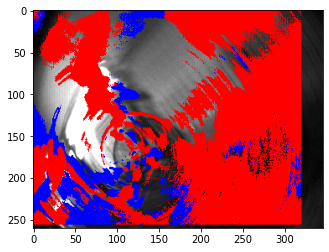

the number of sim event stream 84641


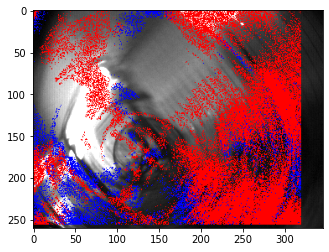

In [13]:
# 将生成的事件画到图片上

# 获取第一帧到第二帧之间的事件
timestamps_ns0=(timestamp_imgs_us[0]-timestamp_imgs_us[0])*1e3 #读取时间戳(注意要从0开始)
timestamps_ns1=(timestamp_imgs_us[1]-timestamp_imgs_us[0])*1e3 #读取时间戳
sim_mask = (all_event['t'] >= timestamps_ns0) & (all_event['t'] < timestamps_ns1)

sim_event_stream = {k: v[sim_mask].cpu().numpy() for k, v in all_event.items()}
print("the number of sim event stream",len(sim_event_stream['x']))

image=image_set[1]
# 将image_color重新生成一次
image_color = np.stack([image,image,image],-1)
xytp = np.stack([sim_event_stream['x'],
                 sim_event_stream['y'], 
                 sim_event_stream['t'], 
                 sim_event_stream['p']], -1).astype(np.int64)  # (N,4)
neg_mask = (xytp[:, -1] == -1)
pos_mask = (xytp[:, -1] == 1)

# 这样做法避免了叠加产生粉红色
image_color[xytp[neg_mask][:, 1], xytp[neg_mask][:, 0]] = np.array([[0., 0., 255.,]]) #将-事件的位置设置为blue
image_color[xytp[pos_mask][:, 1], xytp[pos_mask][:, 0]] = np.array([[255., 0., 0.,]]) #将+事件的位置设置为red

plt.imshow(image_color)
plt.show()

sim_mask = np.random.choice(sim_mask.cpu().sum(), 84641, replace=False)
sim_event_stream = {k: v[sim_mask].cpu().numpy() for k, v in all_event.items()}
print("the number of sim event stream",len(sim_event_stream['x']))
image_color = np.stack([image,image,image],-1)
xytp = np.stack([sim_event_stream['x'],
                 sim_event_stream['y'], 
                 sim_event_stream['t'], 
                 sim_event_stream['p']], -1).astype(np.int64)  # (N,4)
neg_mask = (xytp[:, -1] == -1)
pos_mask = (xytp[:, -1] == 1)

# 这样做法避免了叠加产生粉红色
image_color[xytp[neg_mask][:, 1], xytp[neg_mask][:, 0]] = np.array([[0., 0., 255.,]]) #将-事件的位置设置为blue
image_color[xytp[pos_mask][:, 1], xytp[pos_mask][:, 0]] = np.array([[255., 0., 0.,]]) #将+事件的位置设置为red

plt.imshow(image_color)
plt.show()
